In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Identification").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

#spark.sql("USE 2023_04_01")




SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-01-15 21:26:52,365 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-15 21:26:53,544 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-01-15 21:26:55,525 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

In [2]:
spark.sql("USE 2023_11_02")

DataFrame[]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, lit, udf, pandas_udf, PandasUDFType, coalesce, \
            month, year, concat, date_format, format_string, last_day, months_between, greatest, least, when, lag, count, desc, expr, log1p
from pyspark.sql.window import Window
from datetime import timedelta
from pyspark.sql.types import*
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import csv
import math
#import pyspark.pandas as ps
import seaborn as sns

In [4]:
from CreateDataset import get_fund_data

In [5]:
from pyspark.sql.functions import datediff

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id,p.p_date AS date, p.p_price AS price, splits.p_split_date, IF(ISNULL(splits.p_split_factor),1,splits.p_split_factor) AS split_factor, ms.p_com_shs_out
                FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id
                LEFT JOIN fp_basic_dividends AS divs ON divs.p_divs_exdate = p.p_date AND p.fsym_id = divs.fsym_id
                LEFT JOIN (SELECT sf.fsym_id, mp.price_date, sf.p_com_shs_out, sf.p_date AS shares_hist_date
                                        FROM fp_basic_shares_hist AS sf
                                        JOIN (SELECT p2.fsym_id, p2.p_date AS price_date, max(h.p_date) AS max_shares_hist_date
                                                FROM fp_basic_prices AS p2
                                                JOIN fp_basic_shares_hist AS h ON h.p_date <= p2.p_date AND p2.fsym_id = h.fsym_id
                                                GROUP BY p2.fsym_id, p2.p_date)
                                        mp ON mp.fsym_id = sf.fsym_id AND mp.max_shares_hist_date = sf.p_date)
                            ms ON ms.fsym_id = p.fsym_id AND ms.price_date = p.p_date
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD" 
                AND ms.p_com_shs_out IS NOT NULL
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS") AND p.p_date >= '2000-01-01'
                ORDER BY s.fsym_id, p.p_date"""
    


    adj = spark.sql(query)
    div_query = """SELECT fsym_id, p_divs_exdate AS date, SUM(p_divs_pd) AS div FROM fp_basic_dividends 
                    GROUP BY fsym_id, p_divs_exdate
                    ORDER BY fsym_id, p_divs_exdate"""
    df_div = spark.sql(div_query)
    df_div = df_div.withColumn('weekday', F.dayofweek('date'))
    dic = {1:2, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1}
    df_div = df_div.na.replace(dic, subset="weekday")
    df_div = df_div.withColumn('date_adj', F.expr("date_sub(date, weekday)"))
    df = adj.join(df_div, (adj.fsym_id == df_div.fsym_id) & (adj.date == df_div.date_adj), how='left') \
          .select(adj.fsym_id, adj.date, adj.price, df_div.div, adj.split_factor, adj.p_com_shs_out) \
          .na.fill(0, subset='div') \
          .orderBy(F.col('fsym_id').asc(), F.col('date').desc())
    window_spec = Window.partitionBy("fsym_id").orderBy(F.desc("date"))

    df = df.withColumn("cum_split", F.lag(F.exp(F.sum(F.log("split_factor")).over(window_spec))).over(window_spec))
    df = df.na.fill(1, subset='cum_split') # Set cumulative split factor of latest date to 1

    # Split-adjusted price and dividends
    df = df.withColumn("price_split_adj", F.col('price') * F.col('cum_split'))
    df = df.withColumn("div_split_adj", F.col('div') * F.col('cum_split'))

    # Dividend factor
    df = df.withColumn('div_factor', (F.col('price_split_adj') - F.lag('div_split_adj').over(window_spec))/F.col('price_split_adj'))
    df = df.na.fill(1, subset='div_factor') # Set dividend factor of latest date to 1

    # Cumulative dividend factor
    df = df.withColumn("cum_div", F.exp(F.sum(F.log("div_factor")).over(window_spec)))
    df = df.na.fill(1, subset='cum_div') # Set cumulative dividend factor of latest date to 1

    # Price adjusted for splits and dividends
    df = df.withColumn('adj_price', F.col('price_split_adj') * F.col('cum_div'))
    df = df.withColumn('market_value', F.col('adj_price') * F.col('p_com_shs_out'))
    df = df.withColumn('weekly_return', F.log(df.adj_price / F.lead(df.adj_price).over(window_spec)))
    df = df.orderBy('fsym_id','date')
    

                         
    
    df = df.withColumn('year', F.year('date'))
    
    df = df.withColumn('week_of_year', F.weekofyear('date'))

    window_spec = Window.partitionBy('fsym_id', 'year', 'week_of_year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1)
    df = df.select('fsym_id', 'date', 'adj_price', 'market_value').orderBy('fsym_id','date')
    df.show()
    
#     adj = adj.drop('temp_cum_split_factor', 'cum_split_factor', 'cum_split_factor_no_lag', 'row_num', 'p_split_date', 'p_split_factor', 'split_adj_price', 
#               'cum_spin_factor', 'temp_cum_spin_factor', 'div_factor', 'split_adj_div', 'div_split_factor')
    




    df = df.withColumn('Implosion_Start_Date', F.lit(None).cast(DateType()))
    df = df.withColumn('Implosion_End_Date', F.lit(None).cast(DateType()))
    # adj = adj.withColumn('Market_Value', col('split_adj_price') * col('p_com_shs_out'))
    
    window_spec2 = Window().partitionBy('fsym_id').orderBy('date').rowsBetween(-52, Window.currentRow)
    df = df.withColumn('rolling_mean', F.avg('adj_price').over(window_spec2))
#     window_spec3 = Window().partitionBy('fsym_id', 'year').orderBy('p_date')
#     adj = adj.withColumn('mv_per_year', F.avg('Market_Value').over(window_spec3))
#     adj = adj.withColumn('mv_prev_year', F.lag('Market_Value').over(window_spec3))
    
    
    def implosion_wrapper(adj, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=0.2):
    
        @pandas_udf(adj.schema, FloatType(), PandasUDFType.GROUPED_MAP)
        def find_implosion_price(df1):
            max_price = df1['adj_price'].max()
            fsym_id = df1.loc[0,'fsym_id']
            df1 = df1.sort_values(by='date')
            i = 52 #lookback
            imp_dates = []
            while i < len(df1) and max_price > 100:
                current_date = df1.loc[i, 'date']
                current_price = df1.loc[i, 'adj_price']
                mean_price = df1.loc[i, 'rolling_mean']
                if (current_price - mean_price)/mean_price < price_drop_thresh:
                    j = i
                    start_price=current_price
                    j+=1
                    imp_period=0
                    while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price) / start_price <= increase_thresh:
                        imp_period+=1
                        j+=1
                    if j==len(df1) and imp_period > period_thresh:
                        imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
                    i+=imp_period
                i+=1
            if len(imp_dates)>0:
                df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
                df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]

            return df1
        adj_price = adj.groupBy('fsym_id').apply(find_implosion_price)
        return adj_price
    
    def crash_wrapper(adj, price_drop_thresh=-0.8, period_thresh=78, increase_thresh=0.0):
    
        @pandas_udf(adj.schema, FloatType(), PandasUDFType.GROUPED_MAP)
        def find_crash(df1):
            max_price = df1['adj_price'].max()
            fsym_id = df1.loc[0,'fsym_id']
            df1 = df1.sort_values(by='date')
            i = 1 #lookback
            imp_dates = []
            while i < len(df1) and max_price >= 100.0:
                current_date = df1.loc[i, 'date']
                current_price = df1.loc[i, 'adj_price']
                prev_price = df1.loc[i-1, 'adj_price']
                if (current_price - prev_price)/prev_price < price_drop_thresh:
                    j = i
                    start_price=current_price
                    j+=1
                    imp_period=0
                    while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price) / start_price <= increase_thresh:
                        imp_period+=1
                        j+=1
                    if imp_period > period_thresh:
                        imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
                    i+=imp_period
                i+=1
            if len(imp_dates)>0:
                df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
                df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]

            return df1
        adj_price = adj.groupBy('fsym_id').apply(find_implosion_price)
        return adj_price
    
    @pandas_udf(adj.schema, FloatType(), PandasUDFType.GROUPED_MAP)
    def find_implosion_mv(df1):
        fsym_id = df1.loc[0,'fsym_id']
        df1 = df1.sort_values(by='date')
        i = 52 #lookback
        imp_dates = []
        while i < len(df1):
            current_date = df1.loc[i, 'date']
            current_mv = df1.loc[i, 'Market_Value']
            prev_year_mv = df1.loc[i, 'mv_per_year']
            if (current_mv - prev_year_mv)/prev_year_mv < mv_drop_thresh:
                j = i
                start_mv = current_mv
                j+=1
                imp_period=0
                while j < len(df1) and (df1.loc[j, 'Market_Value'] - start_mv) / start_mv <= increase_thresh:
                    imp_period+=1
                    j+=1
                if imp_period > period_thresh:
                    imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
                i+=imp_period
            i+=1
        if len(imp_dates)>0:
            df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
            df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]
        
        return df1

    

    # adj = adj.filter(col('ticker_region')=='AAPL-US').orderBy('fsym_id', 'p_date')
    # find_implosion2(ps.DataFrame(adj))
    
    df = implosion_wrapper(df)
    result_df = df.groupBy('fsym_id').agg(F.first('Implosion_Start_Date').alias('Implosion_Start_Date'), F.first('Implosion_End_Date').alias('Implosion_End_Date'))
    result_df.show(2)
    result_df.toPandas().to_csv('imploded_stocks_price.csv')
    
    def find_optimal_params():
        price_drop_threshs = [-0.6, -0.8]
        period_threshs= [52, 78, 104]
        increase_threshs = [0.0, 0.2, 0.4]
        results = []
        for price_drop in price_drop_threshs:
            for period in period_threshs:
                for inc in increase_threshs:
                    adj_price = implosion_wrapper(df, price_drop, period, inc)
                    result_df_price = adj_price.groupBy('fsym_id').agg(F.first('Implosion_Start_Date').alias('Implosion_Start_Date'), F.first('Implosion_End_Date').alias('Implosion_End_Date'))
                    filtered_df = result_df_price.filter(col("Implosion_Start_Date").isNotNull())
                    filtered_df = filtered_df.withColumn('imp_length', datediff(col('Implosion_Start_Date'), col('Implosion_End_Date')))
                    mean_length = filtered_df.agg(F.mean('imp_length')).collect()[0][0]
                    results.append({'price_drop':price_drop, 'period_thresh':period, 'increase_thresh':inc, "num_imploded":filtered_df.count(), 'avg_imp_len' : mean_length})
                    print("Working\n")
        return results
    
    
    #adj_mv = adj.groupBy('fsym_id').apply(find_implosion_mv)
    #result_df_mv = adj_mv.groupBy('fsym_id').agg(F.first('Implosion_Start_Date').alias('Implosion_Start_Date'), F.first('Implosion_End_Date').alias('Implosion_End_Date'))
    #filtered_df2 = result_df_mv.filter(col("Implosion_Start_Date").isNull())
    #joined_df = filtered_df1.join(filtered_df2, "fsym_id", "inner")
    
    
#     print("Number imploded by price metric: ", filtered_df1.count())
#     print("Imploded market val: ", filtered_df2.count()) 
#     print("Common stocks: ", joined_df.count())
#     print("Imploded only (price): ", filtered_df1.count() - joined_df.count())
#     print("Imploded only (market val): ", filtered_df2.count() - joined_df.count())
    
#     result_df_price.toPandas().to_csv('imploded_stocks_price.csv')
#     result_df_mv.toPandas().to_csv('imploded_stocks_mv.csv')
    
    

#     exp1_results = find_optimal_params()
#     results_df = pd.DataFrame(exp1_results)
#     print(results_df.head())
#     results_df.to_csv('exp1_results.csv')
    
    
    
get_all_stocks_df()

+--------+----------+------------------+------------------+
| fsym_id|      date|         adj_price|      market_value|
+--------+----------+------------------+------------------+
|B00FG1-R|2014-05-09|13.387249419074875| 212677.2474203522|
|B00FG1-R|2014-05-16|13.019680432134958|206843.66302532807|
|B00FG1-R|2014-05-23|12.932624619438661|  205460.607329022|
|B00FG1-R|2014-05-30|12.937461053477344|205537.44375659456|
|B00FG1-R|2014-06-06|13.933766465446066|221365.74783654165|
|B00FG1-R|2014-06-13|13.150264151179403|208918.24656978718|
|B00FG1-R|2014-06-20|13.363067248881459|212299.04938297972|
|B00FG1-R|2014-06-27| 12.94713392155471|205691.11661173968|
|B00FG1-R|2014-07-04|13.034189734251006|207074.17230804573|
|B00FG1-R|2014-07-11|12.937702875179278| 205541.2855779732|
|B00FG1-R|2014-07-18| 13.24215639791438|210378.13869366577|
|B00FG1-R|2014-07-25|13.010007564057592|206689.99017018295|
|B00FG1-R|2014-08-01|11.699333939574467|185867.31829801956|
|B00FG1-R|2014-08-08|11.607441692839487|

/opt/spark/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+--------+--------------------+------------------+
| fsym_id|Implosion_Start_Date|Implosion_End_Date|
+--------+--------------------+------------------+
|BHZYXG-R|                null|              null|
|BW85Z6-R|                null|              null|
+--------+--------------------+------------------+
only showing top 2 rows



In [13]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
print(len(df))
df = df[df['Implosion_Start_Date'].notnull()]
print(len(df))

10826
608


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with la

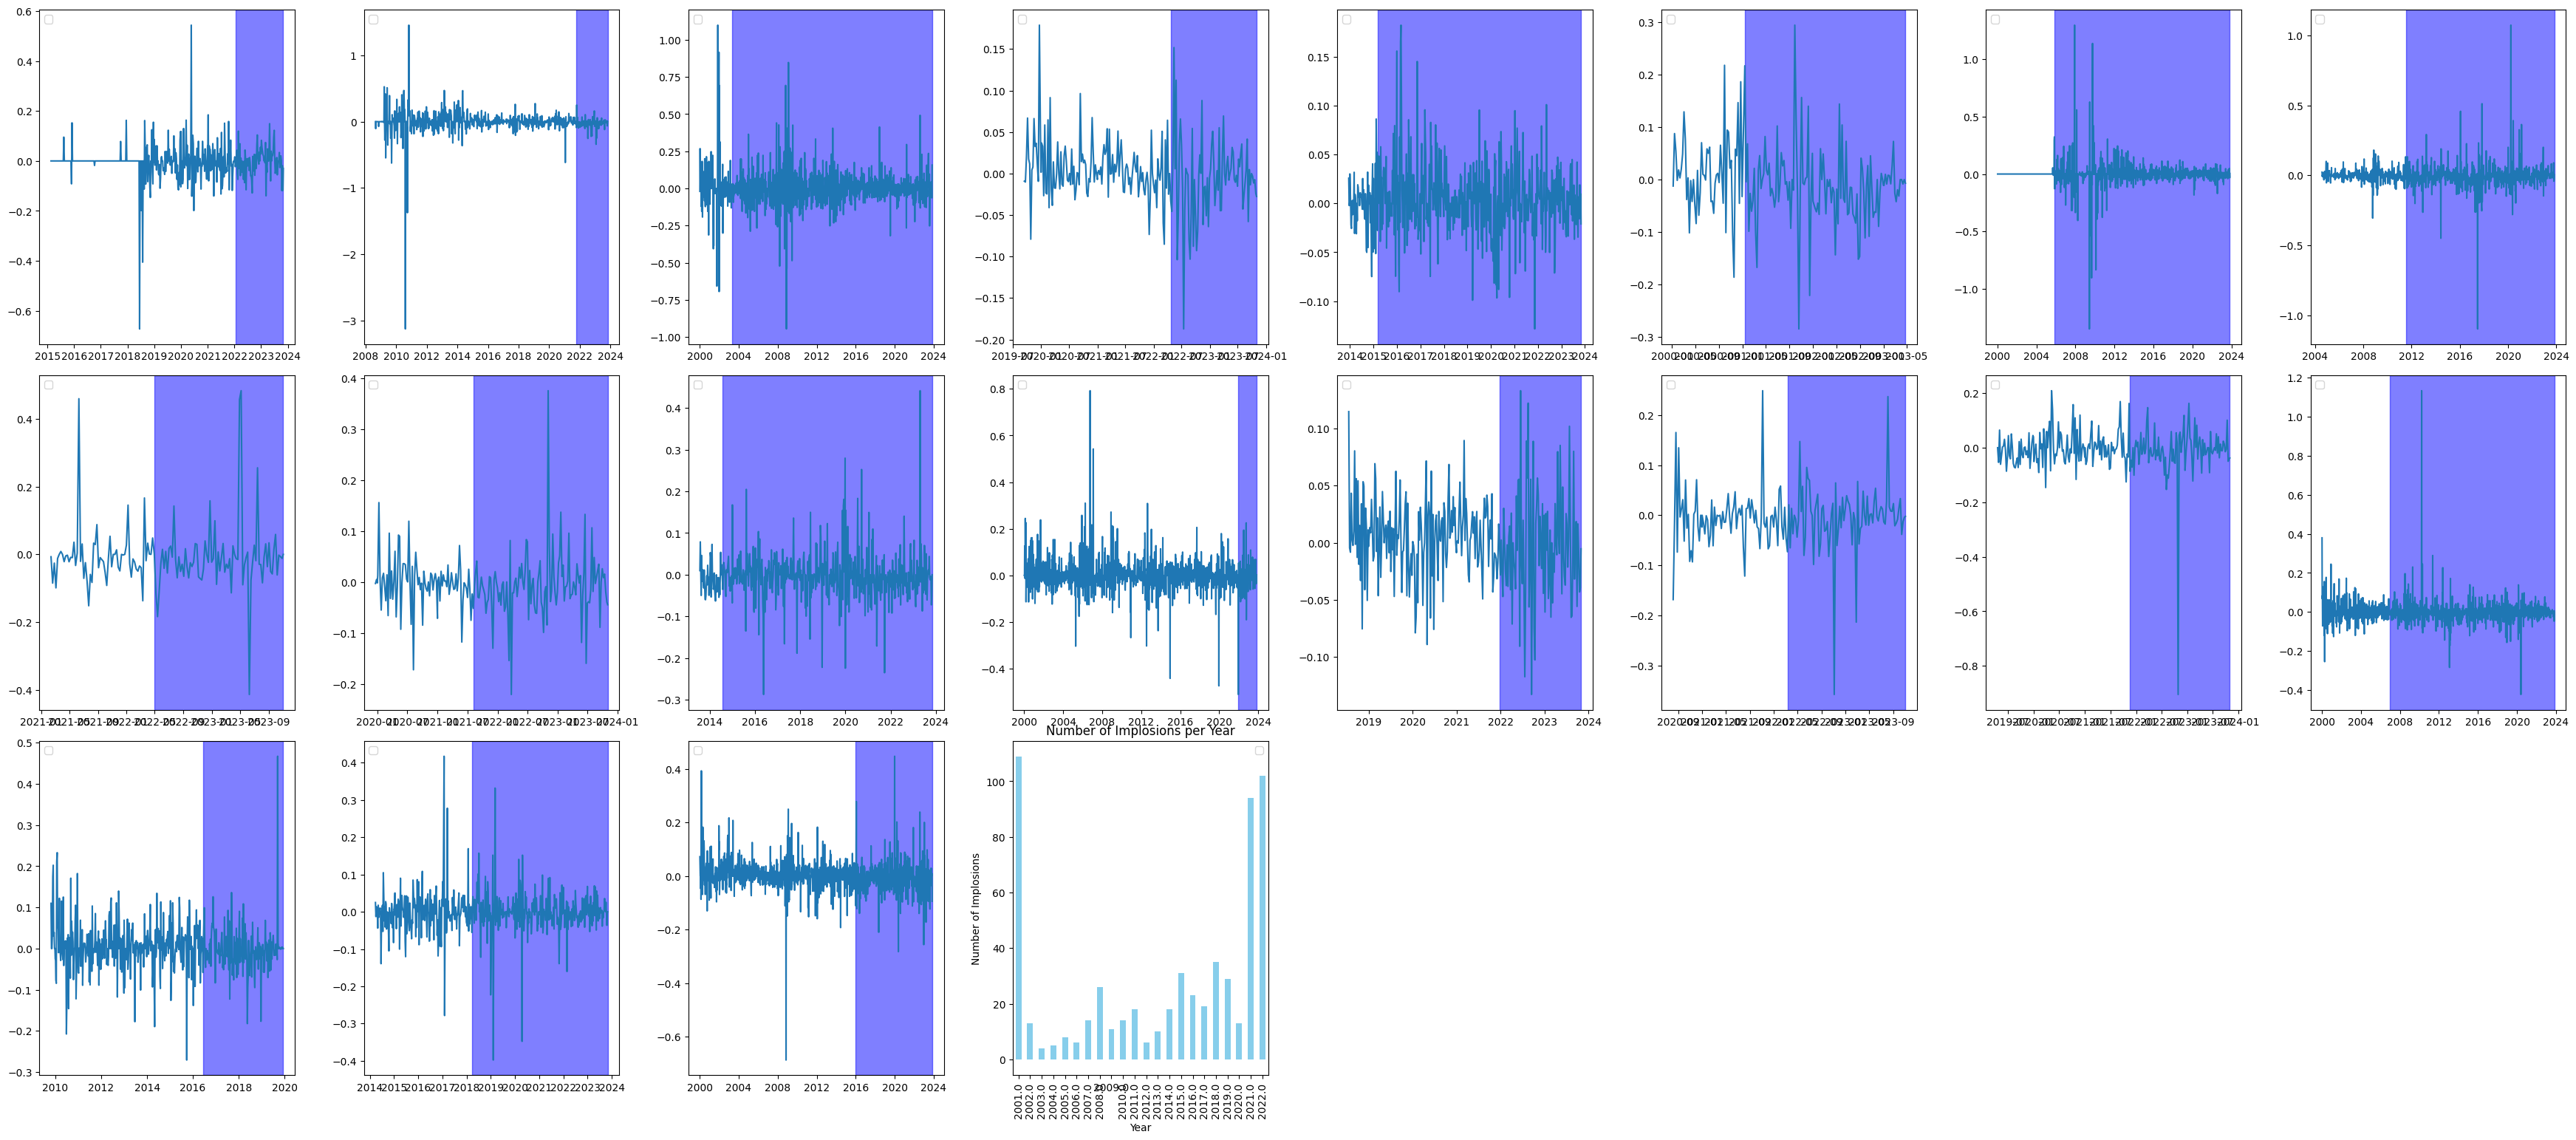

In [5]:
def plot_prices(imp_df, pic_name):
    adj = get_fund_data(imp_df)
    imp_df = imp_df.toPandas()
    adj_pd = adj.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        stdev = temp_df.loc[(imp_df['Implosion_Start_Date'].iloc[0] < temp_df['date']) & (temp_df['date'] < imp_df['Implosion_End_Date'].iloc[0]), ['adj_price']].std()
        axs[i].plot(temp_df['date'], temp_df['weekly_return'])
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(52).mean(), label=f'{t} (52-week)')
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(5).mean(), label=f'{t} (5-week)')
        
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=7, adjust=False).mean())
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=52, adjust=False).mean())
        
        imp_start_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_End_Date'].iloc[0]
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            imp_start_date = pd.to_datetime(imp_start_date)
            imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)
    
    
def sample_plots():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only = spark.createDataFrame(imps_only.head(20))
    plot_prices(imps_only, 'sample_implosions.png')
    
def sample_plots_2022():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only['Implosion_Start_Date'] = pd.to_datetime(imps_only['Implosion_Start_Date'])
    imps_only['year'] = imps_only['Implosion_Start_Date'].dt.year
    imps_only = imps_only[imps_only['year']==2022]
    imps_only = spark.createDataFrame(imps_only.tail(40))
    plot_prices(imps_only, 'sample_implosions_2022.png')
    compare_with_yahoo(imps_only)

def number_imploded():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    print("Number imploded: ", len(imps_only))
    
def visualize_implosions():
    df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    df['Implosion_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
    df['year'] = df['Implosion_Date'].dt.year

    implosions_per_year = df.groupby('year').size()

    implosions_per_year.plot(kind='bar', color='skyblue')

    plt.title('Number of Implosions per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Implosions')

    plt.show()

def compare_with_yahoo(df):
    df.createOrReplaceTempView('temp')
    q = """SELECT str.ticker_region, t.fsym_id FROM temp t LEFT JOIN sym_ticker_region str ON str.fsym_id = t.fsym_id"""
    ticker_df = spark.sql(q)
    ticker_df = ticker_df.toPandas()
    list_to_plot = sorted(ticker_df['ticker_region'].tolist())
    
    columns = 3
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(15, 5*num_rows))
    axs = axs.flatten()
    i=0
    for t in list_to_plot:
        stock_data = yf.download(t[:-3], start='2001-01-01', end='2023-11-02')
        if not stock_data.empty:
            stock_data = stock_data['Adj Close'].resample('W').last()
            axs[i].plot(stock_data.index, stock_data, label=ticker_df.loc[ticker_df['ticker_region'] == t, 'fsym_id'])
            axs[i].legend()
        i+=1
            
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    plt.tight_layout()
    plt.savefig('yahoo_stocks.png')
    

sample_plots()
visualize_implosions()
# sample_plots_2022()

In [8]:
def compare_methods():
    imp_df_price = pd.read_csv('imploded_stock4.csv', index_col=False)
    imp_df_mv = pd.read_csv('imploded_stocks_mv.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    imp_df_mv =  imp_df_mv.loc[imp_df_mv['Implosion_Start_Date'].notnull()]
    print("Number imploded via Market Value: ", len(imp_df_mv))
    print("Number imploded via Price: ", len(imp_df_price))
    not_in_price = imp_df_mv[~imp_df_mv['ticker_region'].isin(imp_df_price['ticker_region'])]
    not_in_mv = imp_df_price[~imp_df_price['ticker_region'].isin(imp_df_mv['ticker_region'])]
    print("Number of stocks in price not in mv: ", len(not_in_mv))
    print("Number of stocks in mv not in price: ", len(not_in_price))
    print("Number of stocks in both: ", len(imp_df_price) - len(not_in_mv))
    plot_prices(spark.createDataFrame(not_in_price.head(20)), 'imploded_mv_mv_only.png')
    plot_prices(spark.createDataFrame(not_in_mv.head(20)), 'imploded_mv_price_only.png')
    
def compare_lengths():
    imp_df_price = pd.read_csv('imploded_stocks3.csv', index_col=False)
    imp_df_mv = pd.read_csv('imploded_stocks_mv.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    imp_df_mv =  imp_df_mv.loc[imp_df_mv['Implosion_Start_Date'].notnull()]
    imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
    imp_df_mv['Implosion_Start_Date'] = pd.to_datetime(imp_df_mv['Implosion_Start_Date'])
    imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
    imp_df_mv['Implosion_End_Date'] = pd.to_datetime(imp_df_mv['Implosion_End_Date'])
    imp_df_price['imp_length'] = imp_df_price['Implosion_End_Date']-  imp_df_price['Implosion_Start_Date']
    imp_df_mv['imp_length'] = imp_df_mv['Implosion_End_Date']-  imp_df_mv['Implosion_Start_Date']
    print("Average implosion length (price): ", imp_df_price['imp_length'].mean())
    print("Average implosion length (market val): ", imp_df_mv['imp_length'].mean())

def create_implosion_price_plots():
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
    imp_df_2001 = imp_df_price[imp_df_price['Implosion_Start_Date'].dt.year==2001]
    imp_df_2018 = imp_df_price[imp_df_price['Implosion_Start_Date'].dt.year==2018]
    plot_prices(spark.createDataFrame(imp_df_2001.head(50)), '2001_implosions.png')
    plot_prices(spark.createDataFrame(imp_df_2018.head(50)), '2018_implosions.png')
    
def compare_type_of_stocks_captured():
    imp_df_price = pd.read_csv('imploded_stock4.csv', index_col=False)
    imp_df_mv = pd.read_csv('imploded_stocks_mv.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    imp_df_mv =  imp_df_mv.loc[imp_df_mv['Implosion_Start_Date'].notnull()]
    imp_df_price_series = get_fund_data(imp_df_price)
    imp_df_mv_series = get_fund_data(imp_df_mv)
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date').desc())
    imp_df_price_series = imp_df_price_series.withColumn('row_num', F.row_number().over(window_spec))
    imp_df_mv_series = imp_df_mv_series.withColumn('row_num', F.row_number().over(window_spec))
    
    first_per_stock_price = imp_df_price_series.filter(col('row_num') == 1)
    num_small_cap_price = first_per_stock_price.filter(col('Market_Value') <= 2000000).count()
    num_small_cap_mv = first_per_stock_mv.filter(col('Market_Value') <= 2000000).count()
    
def stock_start_analysis():
    stocks_df = pd.read_csv('imploded_stocks_price.csv')
    stocks_df['Implosion_Start_Date'] = pd.to_datetime(stocks_df['Implosion_Start_Date'])
    stocks_df['Implosion_End_Date'] = pd.to_datetime(stocks_df['Implosion_End_Date'])
    stocks_df = spark.createDataFrame(stocks_df)
    stocks_df.createOrReplaceTempView("temp_table")
    query = f"""SELECT t.fsym_id, c.p_first_date FROM temp_table t LEFT JOIN fp_sec_coverage c ON c.fsym_id=t.fsym_id
                    ORDER BY t.fsym_id
            """
    start_df = spark.sql(query)
    start_df = start_df.toPandas()
    start_df['p_first_date'] = pd.to_datetime(start_df['p_first_date'])
    start_df['Year'] = start_df['p_first_date'].dt.year
    print(start_df.head())
    starts_per_year = start_df.groupby('Year').size()
    print(starts_per_year)
    
    plt.figure(figsize=(10,5))
    starts_per_year.plot(kind='bar')
    plt.title('Earliest dates of stocks')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')

    plt.show()
    


    
    
    
# stock_start_analysis()  
# compare_methods()
# compare_lengths()
#create_implosion_price_plots()

In [9]:
import calendar

def industry_analysis_all():
    #stock_df = get_all_stocks_df()
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    print(len(stock_df))
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Date'].dt.year
    null_count = ind_df['factset_industry_desc'].isnull().sum()
    print("Number with no industry label: ", null_count)
    
    ind_df_grp = ind_df.groupby(['year', 'factset_industry_desc']).size().reset_index(name='count')

    ind_df_grp = ind_df_grp[ind_df_grp['count'] >= 10]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', hue='factset_industry_desc', data=ind_df_grp)

    plt.title('Imploded Stocks by Industry and Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
    
    ind_df_year = ind_df.groupby('year').size().reset_index(name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', data=ind_df_year)

    plt.title('Imploded Stocks by Industry and Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.show()

def industry_plots(industry):
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    print(len(stock_df))
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = f"""SELECT t.fsym_id, t.Implosion_Start_Date, t.Implosion_End_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE e.factset_industry_desc = "{industry}"
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    plot_prices(ind_df.limit(100), f"{industry}_imploded.png")
    
    
def examine_year():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Start_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Start_Date'].dt.year
    ind_df_year = ind_df[ind_df['year'] == 2022]
    ind_df_year['month'] = ind_df_year['Implosion_Start_Date'].dt.month
    ind_df_year['month_name'] = ind_df_year['Implosion_Start_Date'].dt.month_name()

    # Specify the order of months
    month_order = list(calendar.month_name)[1:]  # List of month names excluding the empty string

    ind_df_grp = ind_df_year.groupby(['month_name']).size().reindex(month_order, fill_value=0).reset_index(name='count')
    print(ind_df_grp.head())

    plt.figure(figsize=(12, 6))
    sns.barplot(x='month_name', y='count', data=ind_df_grp, color='skyblue', order=month_order)

    plt.title('Imploded Stocks in 2022')
    plt.xlabel('Month')
    plt.ylabel('Number of Stocks')
    plt.show()

def mkt_val_per_year():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_series = get_fund_data(stock_df)
    stock_series.show()
    stock_series = stock_series.join(stock_df.select("fsym_id", "Implosion_Start_Date"), "fsym_id", "inner")
    stock_series = stock_series.withColumn('year',F.year('Implosion_Start_Date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date'))
    stock_series = stock_series.withColumn('Max_Market_Value', F.max('Market_Value').over(window_spec))
    
    
    filtered_df = stock_series.filter(F.col('Max_Market_Value') < 2e9)

    grouped_df = filtered_df.groupBy('year').agg(F.countDistinct('fsym_id').alias('num_stocks'))

    pandas_df = grouped_df.toPandas()

    plt.bar(pandas_df['year'], pandas_df['num_stocks'])
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks with Market Val < $2bn')
    plt.title('Number of Stocks with Market Val < $2bn')
    plt.show()

# industry_analysis_all()
# examine_year()
# mkt_val_per_year()
# industry_plots('Pharmaceuticals: Major')

In [10]:
def plot_stock_price(ticker):
    # Fetching data from Yahoo Finance
    print(ticker[:-3])
    stock_data = yf.download(ticker[:-3], start='2001-01-01', end='2023-11-02')
    if not stock_data.empty:
        stock_data = stock_data['Adj Close'].resample('W').last()
        print(stock_data.head())
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(stock_data.index, stock_data)
        plt.title(f'{ticker} Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

def compare_prices():
    unique_values = ['AAPL-US', 'ABIO-US', 'PTEK-US', 'AIG-US']
    for u in unique_values:
        q = f"""SELECT str.fsym_id FROM sym_ticker_region str WHERE str.ticker_region = "{u}" """
        qdf = spark.sql(q)
        price_df = get_fund_data(qdf)
        price_df.show()
        #id_t = yf_ticker_df.select('ticker_region').first()[0]
        stock_data = price_df.select('p_date', 'adj_price').orderBy('p_date').toPandas()

        # Convert 'p_date' to datetime if needed
        stock_data['p_date'] = pd.to_datetime(stock_data['p_date'])
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(stock_data['p_date'], stock_data['adj_price'])
        plt.title('Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        plot_stock_price(u)

# tickers_feats = spark.createDataFrame(df[:5])
# sp_df = get_fund_data(tickers_feats)
#compare_prices()
#plot_stock_price('BHZYXG-R')

In [20]:
def zscore_plots():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_series = get_fund_data(stock_df)
    stock_series.show()
    stock_series = stock_series.join(stock_df.select("fsym_id", "Implosion_Start_Date"), "fsym_id", "inner")
    stock_series.show()
    stock_series.createOrReplaceTempView('temp')
    q =f"""SELECT t.fsym_id, t.date, t.Implosion_Start_Date, t.adj_price, a.date, a.FF_ZSCORE FROM temp t LEFT JOIN FF_ADVANCED_DER_QF a ON YEAR(a.date) = YEAR(t.date)
                AND MONTH(t.date) = MONTH(a.date) AND t.fsym_id = a.fsym_id"""
    z_df = spark.sql(q)
    z_df.show()
    
#     # Convert 'p_date' to datetime if needed
    z_df.toPandas()
    z_df['date'] = pd.to_datetime(stock_data['p_date'])
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['p_date'], stock_data['adj_price'])
    plt.title('Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
# zscore_plots()

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


KeyboardInterrupt: 

In [6]:
# spark.stop()

In [ ]:
#idk where to put this back up code:
#     adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
#     adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
#     adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders

#     window_spec = Window.partitionBy('fsym_id').orderBy(F.desc('p_date'))

#     # Calculate cumulative split factor and dividend split factor
#     #adj = adj.withColumn('split_temp_i', F.row_number().over(window_spec) - 1)
#     adj = adj.withColumn('cum_split_factor_no_lag', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise('div_split_factor'))
#     adj = adj.withColumn('cum_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_split_factor_no_lag', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn('split_adj_price', adj.p_price * adj.cum_split_factor)
#     adj = adj.withColumn('split_adj_div', adj.p_divs_pd * adj.cum_split_factor)
    
#     adj = adj.withColumn("div_factor", when(((adj.p_date == adj.p_divs_exdate) & (adj.p_divs_s_pd == 1)), lit(adj.split_adj_div)).otherwise(lit(0.0)))
    
#     adj = adj.withColumn("temp_cum_spin_factor", when((adj.split_adj_price - adj.div_factor <= 0), lit(1.0)).otherwise(lit((adj.split_adj_price - adj.div_factor)/adj.split_adj_price)))
    
#     adj = adj.withColumn("cum_spin_factor", lit(0.0))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.exp(F.sum(F.log('temp_cum_spin_factor')).over(window_spec)))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_spin_factor', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn("adj_price", adj.split_adj_price * adj.cum_spin_factor)